In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import pandas as pd
from scipy.stats import gamma
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 150)

# Trivial Projector
What happens if we just take a player's cumulative mean fantasy points as the projection?

In [2]:
from dfsmc.projection import projection

projection_trainer = projection.ProjectionModelTrainer(list(range(2017,2024)), projection.TrivialProjector)
projection_trainer.prepare_data()
print(projection_trainer.prepared_data.columns)
print(len(projection_trainer.prepared_data))
print(len(projection_trainer.prepared_data[['name_display', 'year', 'week_num']].drop_duplicates()))
print(projection_trainer.prepared_data.sort_values(by='draftkings_points', ascending=False).head(100))

Index(['name_display', 'draftkings_points_predicted', 'team_name_abbr', 'pos_game', 'game_location', 'opp_name_abbr', 'week_num', 'year',
       'draftkings_points', 'rush_att', 'pass_att', 'targets'],
      dtype='object')
31059
31059
             name_display  draftkings_points_predicted team_name_abbr pos_game game_location opp_name_abbr  week_num  year  draftkings_points  \
2860          Tyreek Hill                    20.820000            KAN       WR             @           TAM        12  2020               60.9   
3751         Alvin Kamara                    23.185714            NOR       RB                         MIN        16  2020               59.2   
4153        Ja'Marr Chase                    17.160000            CIN       WR                         KAN        17  2021               58.6   
1977            Joe Mixon                    14.575000            CIN       RB                         CAR         9  2022               58.1   
1032          Will Fuller              

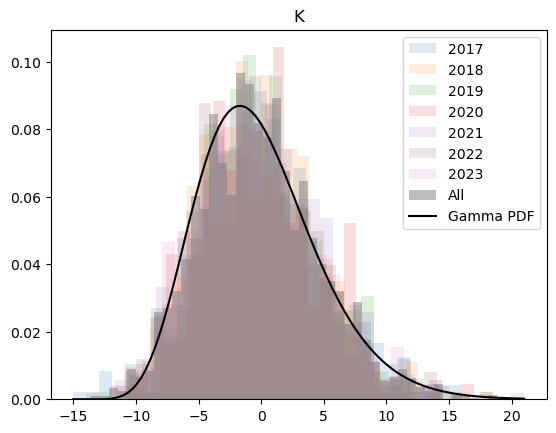

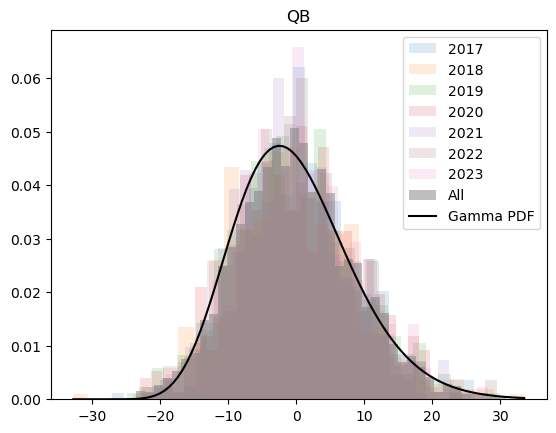

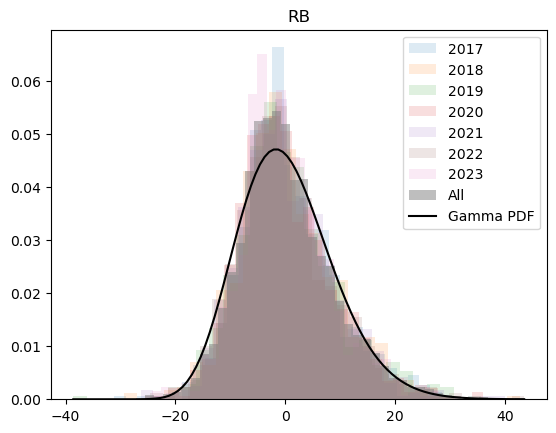

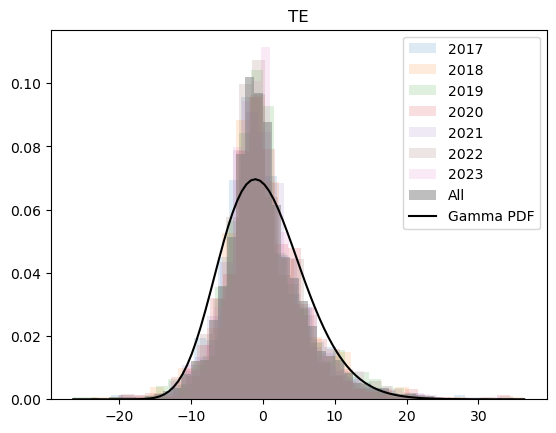

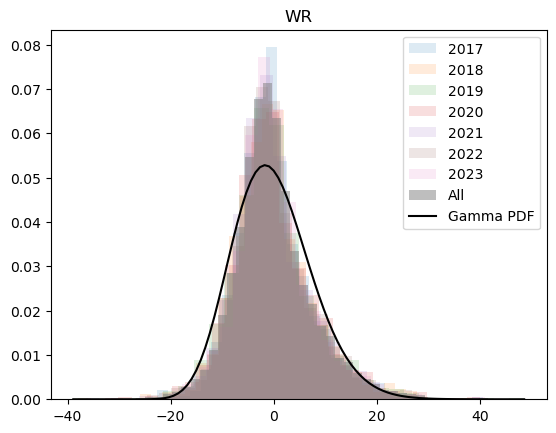

In [3]:
residuals = projection_trainer.get_residuals()
gamma_results = projection_trainer.get_gamma()
# print(residuals.head(10))
res_grouped = residuals.groupby('pos_game')[['year', 'res']]

for pos, df in res_grouped:
    plt.figure()
    year_grouped = df.groupby('year')[['res']]
    for year, df1 in year_grouped:
        plt.hist(df1['res'].values, density=True, bins=30, alpha=0.15, label=year)
        
    
    plt.hist(df['res'].values, density=True, bins=50, alpha=0.5, label='All')
    # fit and plot gamma
    gamma_vals = gamma_results[pos]
    x = np.linspace(0, np.max(df['res'].values) - np.min(df['res'].values), 100)
    pdf = gamma.pdf(x, gamma_vals[0], 0.0, 1/gamma_vals[1])
    plt.plot(x+gamma_vals[2], pdf, color='black', label='Gamma PDF')
    plt.title(pos)
    plt.legend()

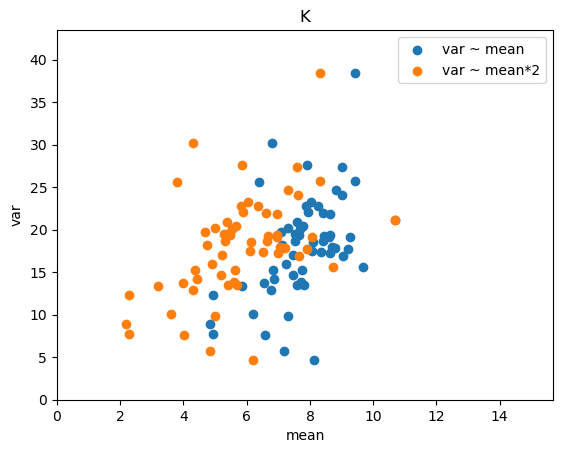

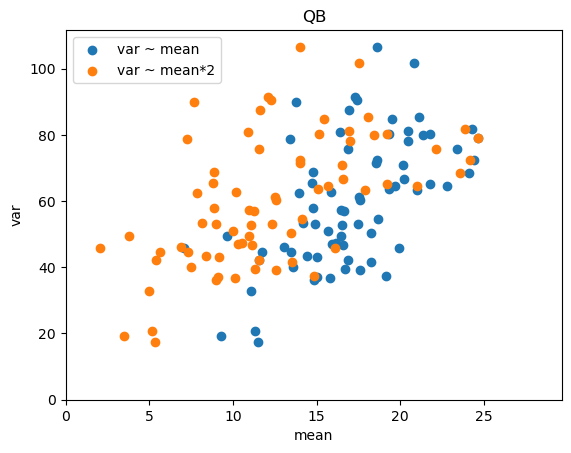

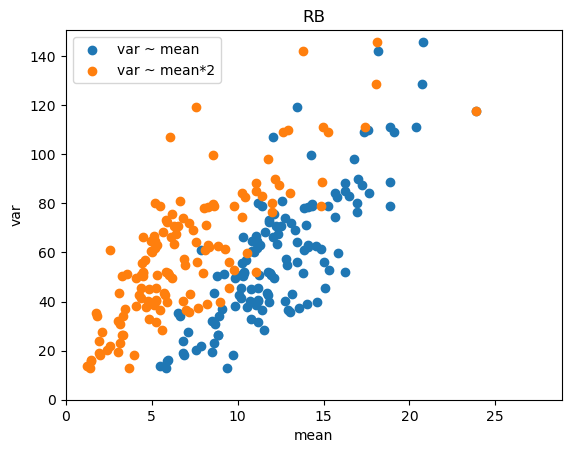

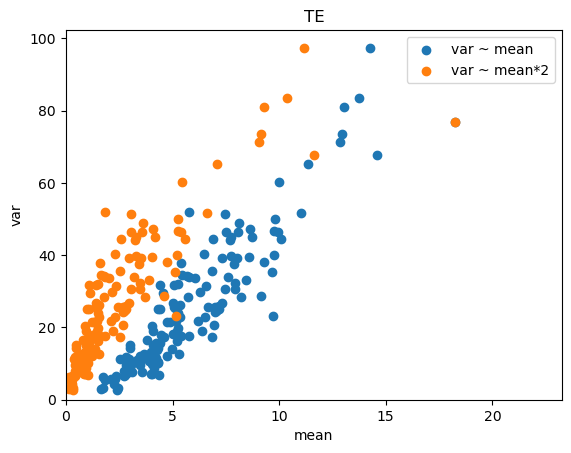

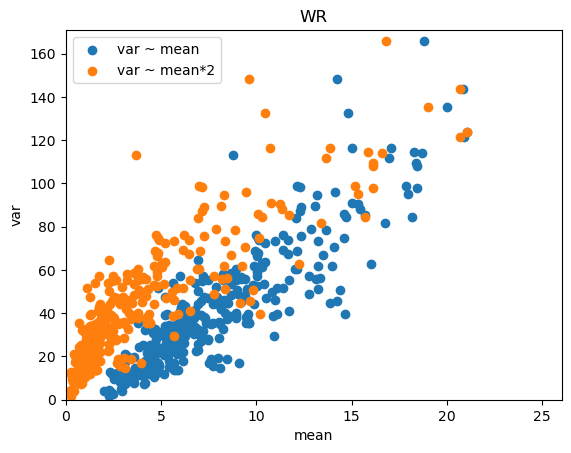

In [9]:
# Do single-player covariances scale with their mean score?
data = projection_trainer.prepared_data.copy()
grouped = data.groupby('pos_game')

for pos, df in grouped:
    stats = df.groupby('name_display')[['draftkings_points', 'draftkings_points_predicted', 'res']].agg(['mean', 'std', 'count'])
    stats = stats.loc[stats[('res', 'count')] > 10]
    plt.figure()
    plt.scatter(stats[('draftkings_points', 'mean')].values, stats[('draftkings_points', 'std')].values**2, label='var ~ mean')
    plt.scatter((stats[('draftkings_points', 'mean')].values**2) * np.max(stats[('draftkings_points', 'mean')].values) / np.max(stats[('draftkings_points', 'mean')].values**2), stats[('draftkings_points', 'std')].values**2, label='var ~ mean*2')
    plt.xlabel('mean')
    plt.ylabel('var')
    plt.xlim([0, np.max(stats[('draftkings_points', 'mean')].values) + 5])
    plt.ylim([0, np.max(stats[('draftkings_points', 'std')].values**2) + 5])
    plt.legend()
    plt.title(pos)

plt.show();